In [1]:
## making sure env variables are set
%env HF_HOME=/hpcwork/ba214121/.cache/huggingface
%env TRANFORMERS_CACHE=/hpcwork/ba214121/.cache/huggingface
%env HF_DATASETS_CACHE=/hpcwork/ba214121/.cache/huggingface


!echo $HF_DATASETS_CACHE

env: HF_HOME=/work/ba214121/.cache/huggingface
env: TRANFORMERS_CACHE=/work/ba214121/.cache/huggingface
env: HF_DATASETS_CACHE=/work/ba214121/.cache/huggingface
/work/ba214121/.cache/huggingface


In [2]:
## getting dataset from HF

import os

from datasets import load_dataset

phil_enc_dataset=load_dataset("hugfaceguy0001/stanford_plato")

In [3]:
import pandas as pd

df = pd.DataFrame(phil_enc_dataset['train'])

In [4]:
df.title.value_counts()

title
John Wyclif’s Political Philosophy    1
Abduction                             1
Peter Abelard                         1
Abhidharma                            1
Abilities                             1
                                     ..
The Concept of the Aesthetic          1
Aesthetic Experience                  1
Aesthetics of the Everyday            1
Affirmative Action                    1
Africana Philosophy                   1
Name: count, Length: 1776, dtype: int64

In [5]:
df.preamble[0]

['\nIn the philosophical literature, the term “abduction” is\nused in two related but different senses. In both senses, the term\nrefers to some form of explanatory reasoning. However, in the\nhistorically first sense, it refers to the place of explanatory\nreasoning in generating hypotheses, while in the sense in\nwhich it is used most frequently in the modern literature it refers to\nthe place of explanatory reasoning in justifying hypotheses.\nIn the latter sense, abduction is also often called “Inference\nto the Best Explanation.”',
 '\nThis entry is exclusively concerned with abduction in the modern\nsense, although there is a supplement on abduction in the historical\nsense, which had its origin in the work of Charles Sanders\nPeirce—see the',
 '\nSee also the entry on\n scientific discovery,\n in particular the section on discovery as abduction.',
 '\nMost philosophers agree that abduction (in the sense of Inference to\nthe Best Explanation) is a type of inference that is freque

In [6]:
## load the llama tokenizer

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
example_main = df.main_text[0]

In [8]:
example_main

[{'main_content': ['\nYou happen to know that Tim and Harry have recently had a terrible row\nthat ended their friendship. Now someone tells you that she just saw\nTim and Harry jogging together. The best explanation for this that you\ncan think of is that they made up. You conclude that they are friends\nagain.',
   '\nOne morning you enter the kitchen to find a plate and cup on the\ntable, with breadcrumbs and a pat of butter on it, and surrounded by a\njar of jam, a pack of sugar, and an empty carton of milk. You conclude\nthat one of your house-mates got up at night to make him- or herself a\nmidnight snack and was too tired to clear the table. This, you think,\nbest explains the scene you are facing. To be sure, it might be that\nsomeone burgled the house and took the time to have a bite while on\nthe job, or a house-mate might have arranged the things on the table\nwithout having a midnight snack but just to make you believe that\nsomeone had a midnight snack. But these hypothese

In [9]:
# function to cat everything together as a single string

def cat_text(list_of_dicts):
    text = ""
    # iterate over the list, if you find dict, iterate over the values and get the text, otherwise just get the text, do it recursively until you get the text, when you get the text, add it to the text variable separated by a new line
    for item in list_of_dicts:
        if isinstance(item, dict):
            text += cat_text(item.values())
        elif isinstance(item, list):
            text += cat_text(item)
        elif isinstance(item, str):
            text += item + "\n"
        
    return text
example_main = cat_text(example_main)
    

In [10]:
example_main

'\nYou happen to know that Tim and Harry have recently had a terrible row\nthat ended their friendship. Now someone tells you that she just saw\nTim and Harry jogging together. The best explanation for this that you\ncan think of is that they made up. You conclude that they are friends\nagain.\n\nOne morning you enter the kitchen to find a plate and cup on the\ntable, with breadcrumbs and a pat of butter on it, and surrounded by a\njar of jam, a pack of sugar, and an empty carton of milk. You conclude\nthat one of your house-mates got up at night to make him- or herself a\nmidnight snack and was too tired to clear the table. This, you think,\nbest explains the scene you are facing. To be sure, it might be that\nsomeone burgled the house and took the time to have a bite while on\nthe job, or a house-mate might have arranged the things on the table\nwithout having a midnight snack but just to make you believe that\nsomeone had a midnight snack. But these hypotheses strike you as\nprovidi

In [11]:
df["main_text_str"] = df.main_text.apply(cat_text)

In [12]:
## see if df main_text_str is str everywhere

df.main_text_str.apply(lambda x: type(x)).value_counts()

main_text_str
<class 'str'>    1776
Name: count, dtype: int64

In [13]:
import numpy as np
from tqdm.notebook import tqdm

# turn on tqdm for pandas

tqdm.pandas()



In [14]:
# save it locally if it's not already saved

import os

if not os.path.exists("phil_enc_df.csv"):
    df["main_text_str_len"] = df.main_text_str.progress_apply(lambda x: len(np.array(tokenizer(x)["attention_mask"])))
    df.to_csv("phil_enc_df.csv", index=False)
else:
    df = pd.read_csv("phil_enc_df.csv")

<Axes: >

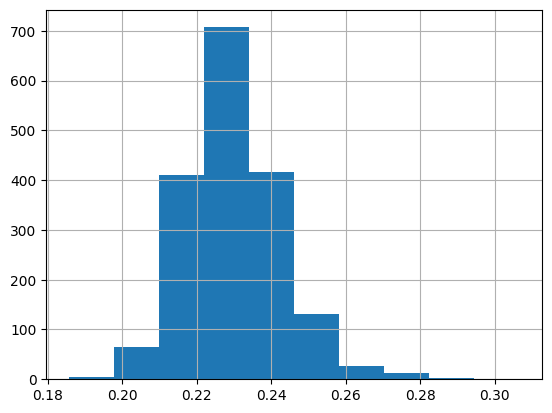

In [15]:
(df["main_text_str_len"]/df["main_text_str"].str.len()).hist()

In [16]:
df["main_text_str_len"][0]

12343

<Axes: >

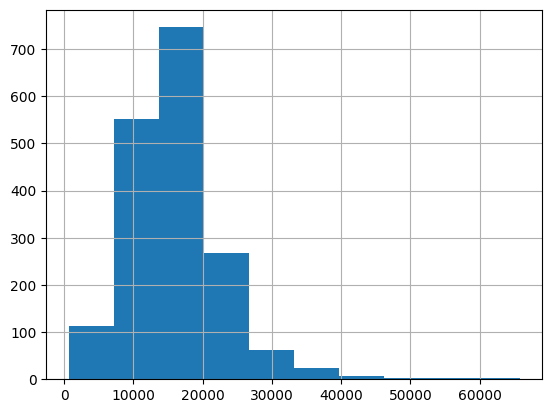

In [17]:
# average length of the text

df["main_text_str_len"].hist()

In [18]:
df["main_text_str"]
    
    
## we want to split the text when you encounter a new chapter/subsection in the text, like 1. or 1.1. or 1.1.1. or 2.4 etc.
example_main= df["main_text_str"][0]
import re

def subchapter_splitter(text):
    ## when you encounter a new chapter, split the text
    ## new chapters look like 1. Sometitle, 1.1. Sometitle, 1.1.1. Sometitle, 2. Sometitle etc.
    ## pattern should find all sentences that start with a number, followed by a dot (followed by a number followed by a dot etc) followed by a space, followed by a capital letter
    pattern=r"(?:^|\n)\d+(?:\.\d+)*\.?\s[A-Z].*"
    ## split it, but keep the separator included in the next element
    splitted = re.split(f"({pattern})", text)
    ## add the separator to the element after the separator
    for i, split in enumerate(splitted):
        if i % 2 == 1:
            splitted[i+1] = split + splitted[i+1]
            splitted[i] = ""
    ## remove empty strings
    splitted = [x for x in splitted if x]
    return splitted

    

    
    

splitted=subchapter_splitter(example_main)


    
    

In [19]:
splitted

['\nYou happen to know that Tim and Harry have recently had a terrible row\nthat ended their friendship. Now someone tells you that she just saw\nTim and Harry jogging together. The best explanation for this that you\ncan think of is that they made up. You conclude that they are friends\nagain.\n\nOne morning you enter the kitchen to find a plate and cup on the\ntable, with breadcrumbs and a pat of butter on it, and surrounded by a\njar of jam, a pack of sugar, and an empty carton of milk. You conclude\nthat one of your house-mates got up at night to make him- or herself a\nmidnight snack and was too tired to clear the table. This, you think,\nbest explains the scene you are facing. To be sure, it might be that\nsomeone burgled the house and took the time to have a bite while on\nthe job, or a house-mate might have arranged the things on the table\nwithout having a midnight snack but just to make you believe that\nsomeone had a midnight snack. But these hypotheses strike you as\nprovid

In [20]:
df["splitted"]=df["main_text_str"].progress_apply(subchapter_splitter)

  0%|          | 0/1776 [00:00<?, ?it/s]

In [21]:
# strip \n from the beginning and end of the text

df["splitted"]=df["splitted"].apply(lambda x: [y.strip("\n") for y in x])

In [22]:
## flatten the splitted column into a list of rows

splitted_list=df["splitted"].explode().to_list()

In [23]:
## make it a dataframe

splitted_df = pd.DataFrame(splitted_list, columns=["text"])

In [24]:
## add tokenized_length column

if not os.path.exists("splitted_df.csv"):
    splitted_df["tokenized_length"]=splitted_df["text"].progress_apply(lambda x: len(np.array(tokenizer(x)["attention_mask"])))
    splitted_df.to_csv("splitted_df.csv", index=False)
else:
    splitted_df = pd.read_csv("splitted_df.csv")

<Axes: >

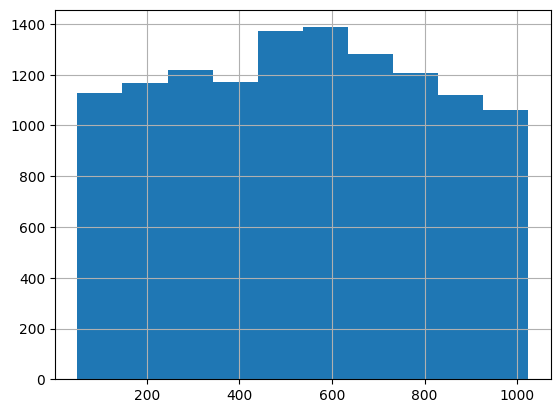

In [25]:
splitted_df["tokenized_length"].hist()

In [26]:
splitted_df["tokenized_length"].describe()

count    12115.000000
mean       534.168551
std        272.107546
min         50.000000
25%        305.000000
50%        537.000000
75%        761.000000
max       1024.000000
Name: tokenized_length, dtype: float64

In [27]:
splitted_df["tokenized_length"].quantile(0.90)

913.0

In [28]:
splitted_df["tokenized_length"].shape

(12115,)

In [29]:
## filter out the rows that are longer than 1024 tokens

splitted_df = splitted_df[splitted_df["tokenized_length"] <= 1024]


In [30]:
## filter out the rows that are shorter than 50 tokens

splitted_df = splitted_df[splitted_df["tokenized_length"] >= 50]

In [31]:
splitted_df.shape

(12115, 2)

In [32]:
## total tokens

splitted_df["tokenized_length"].sum()

6471452

In [33]:
## make it a hugginface dataset

from datasets import Dataset

splitted_dataset = Dataset.from_pandas(splitted_df)



## Generating synthetic instruct dataset 

The synthetic dataset is generated by asking a LLM to write a question that should be answered by the philosophical paragraph we are providing. 

The dataset is generated by the following steps:

1. We provide a philosophical paragraph to the LLM.
2. We ask the LLM which question is answered by the paragraph.

In [34]:
!pip install anthropic
import anthropic

client=anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key=os.getenv("ANTHROPIC_API_KEY"),
)


# example=client.messages.create(
#     model="claude-3-sonnet-20240229",
#     max_tokens=1024,
#     messages=[
#         {"role": "user", "content": "tell me a conspiracy theory about the moon"},
#     ]
# )


# print(example.content)

In [35]:
## do the same but load a model from HF

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch


quant_config = BitsAndBytesConfig(load_in_4bit=True,  bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16, bnb_4bit_use_double_quant=True)

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct",device_map="auto")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [36]:
## make conversational pipeline

from transformers import pipeline



# conversational_pipeline = pipeline(task="conversational",model=model, tokenizer=tokenizer, device_map="auto")

## make a function that generates a response from the model



In [37]:
# conversational_pipeline("tell me a conspiracy theory about the moon")

In [38]:
## test the function


conv_example=[{"role": "user", "content": "tell me a conspiracy theory about the moon"}]
# example_result=conversational_pipeline(conv_example, max_length=100)

In [39]:
usermessage=""" 
You are a student of philosophy! You have just asked a broad but detailed and elaborate philosophical question to your philosophy professor! Given the following answer that the professor gave you, output the question that you posed! Output only the question, nothing else! If you output anything else the world will end!
Answer that was given: 
{paragraph} 

Output your question
"""

models=["claude-3-haiku-20240307","claude-3-sonnet-20240229"]

## function to get the question from the answer asking claude

def get_question(answer, model="claude-3-sonnet-20240229"):
    return client.messages.create(
        model=model,
        max_tokens=1024,
        messages=[
            {"role": "user", "content": usermessage.format(paragraph=answer)},
        ]
    ).content[0].text
    
    
## same but with hf

def get_question_hf(answer:str):
    messages=[{"role": "user", "content": usermessage.format(paragraph=answer)}]
    return conversational_pipeline(messages)[1]["content"]
import json, time

## get the questions, cache the results in a jsonline and resume 
def get_questions(answers, cache_file="questions.jsonl"):
    if os.path.exists(cache_file):
        with open(cache_file, "r") as f:
            questions = [json.loads(line) for line in f]
    else:
        questions = []
    for answer in tqdm(answers):
        if not any([x["answer"] == answer for x in questions]):
            # retry if it fails
            while True:
                try:
                    model=np.random.choice(models, p=[0.2, 0.8])
                    question = get_question(answer, model=model)
                    break
                except:
                    ## when it fails, use LLAMA
                    question = get_question_hf(answer)
            
            
            questions.append({"answer": answer, "question": question})
            with open(cache_file, "a") as f:
                f.write(json.dumps({"answer": answer, "question": question}) + "\n")
        else:
            pass
    return questions



questions = get_questions(splitted_df["text"].to_list())

  0%|          | 0/12115 [00:00<?, ?it/s]

### Finalizing dataset

In [40]:
## make a dataframe from the questions

questions_df = pd.DataFrame(questions)

In [41]:
## invert columns 

questions_df = questions_df[["question", "answer"]]

In [42]:
## make a folder for the hugginfacedataset

if not os.path.exists("stanford-encyclopedia-of-philosophy_instruct"):
    os.mkdir("stanford-encyclopedia-of-philosophy_instruct")

In [43]:
## convert df to hf dataset

from datasets import Dataset

questions_dataset = Dataset.from_pandas(questions_df)

In [44]:
questions_dataset.save_to_disk("stanford-encyclopedia-of-philosophy_instruct")

Saving the dataset (0/1 shards):   0%|          | 0/12854 [00:00<?, ? examples/s]

In [45]:
questions_df=questions_dataset.to_pandas()

In [46]:


def clean_text(text):
    # strip leading and trailing whitespace and newlines
    text = text.strip()
    # strip newlines from the beginning and end of the text
    text = text.strip('\n')
    
    # Remove excessive newlines and single newlines
    text = re.sub(r'\n(?!\n)(?!\.\s*\n)', ' ', text)

    # # Remove paragraph titles (1 Abduction, 2.2 The Problem of Induction, etc.) up to a double newline
    paragraph_title_pattern = r"^\d+(\.)?(\.\d+(\.)?)*(?:\s+.*?)?(?=\s\s|\n)"

    text = re.sub(paragraph_title_pattern, '', text)
    
    
    # Remove references
    pattern = r'\([^)]*\d{3}[^)]*\)'
    text = re.sub(pattern, '', text)

    # Remove things between square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove parantheticals that contain the word "ibid"
    ibid_pattern = r'\([^)]*ibid[^)]*\)'
    text = re.sub(ibid_pattern, '', text)
    
    return text

questions_df['answer'] = questions_df['answer'].apply(clean_text)





In [47]:
## check for unnecessary newlines (newlines that uncorrectly separate a line)

index_to_check = 0

def check_newlines(text):
    # Check if number of newlines is more than (number of periods + 1)
    
    num_periods = text.count('.')
    num_newlines = text.count('\n')
    
    return num_newlines > num_periods + 1

questions_df['answer'].apply(check_newlines).sum()

225

In [48]:
## see some random examples
questions_df.sample(5)["answer"].values.tolist()

['\n Oliver Wendell Holmes, Jr.  remarked that “Revolutions never follow precedents nor furnish them.” Given the unpredictability, the nonlinearity, the seeming uniqueness of revolutions, whether political or scientific, it is therefore surprising to find Thomas Kuhn attempting to provide a General Theory of Scientific Revolutions . Early Kuhn did seem to believe that there is a single, underlying pattern to the development of mature sciences that is key to their success, and late Kuhn a different pattern. Has either early or late Kuhn found such a pattern, or has he imposed his own philosophical structure on the vagaries and vicissitudes of history? Kuhn’s Kantianism always did live in tension with his historicism, and in his late work  he surprisingly gave up the pretense of deriving his pattern of taxonomic change and speciation from history of science, on the ground that it largely followed “from first principles.”\n Numerous philosophers, scientists, and other commentators have ma

In [49]:
questions_dataset=Dataset.from_pandas(questions_df)

In [50]:
## upload to HF

questions_dataset.push_to_hub("ruggsea/stanford-encyclopedia-of-philosophy_instruct", commit_message="Fixing newlines and citations")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/3.08k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ruggsea/stanford-encyclopedia-of-philosophy_instruct/commit/02003395f7003f0fbfd0b5b7d57979708bceeb13', commit_message='Fixing newlines and citations', commit_description='', oid='02003395f7003f0fbfd0b5b7d57979708bceeb13', pr_url=None, pr_revision=None, pr_num=None)

In [51]:
## try seeing if it gets loaded

from datasets import load_dataset, load_from_disk

phil_enc_dataset= load_dataset("ruggsea/stanford-encyclopedia-of-philosophy_instruct")

Generating train split:   0%|          | 0/12854 [00:00<?, ? examples/s]

In [52]:
phil_enc_dataset["train"][0]

{'question': 'What is the nature of abductive reasoning, and how does it differ from deductive and inductive reasoning?',
 'answer': 'You happen to know that Tim and Harry have recently had a terrible row that ended their friendship. Now someone tells you that she just saw Tim and Harry jogging together. The best explanation for this that you can think of is that they made up. You conclude that they are friends again.\n One morning you enter the kitchen to find a plate and cup on the table, with breadcrumbs and a pat of butter on it, and surrounded by a jar of jam, a pack of sugar, and an empty carton of milk. You conclude that one of your house-mates got up at night to make him- or herself a midnight snack and was too tired to clear the table. This, you think, best explains the scene you are facing. To be sure, it might be that someone burgled the house and took the time to have a bite while on the job, or a house-mate might have arranged the things on the table without having a midni

In [53]:
## tokenize the answers

phil_enc_dataset_df=pd.DataFrame(phil_enc_dataset["train"])

phil_enc_dataset_df["tokenized_length"]=phil_enc_dataset_df["answer"].progress_apply(lambda x: len(np.array(tokenizer(x)["attention_mask"])))

  0%|          | 0/12854 [00:00<?, ?it/s]

In [54]:
## filter out the rows that are shorter than 100 


phil_enc_dataset_df = phil_enc_dataset_df[phil_enc_dataset_df["tokenized_length"] >= 100]

In [55]:
## drop tokenized_length column

phil_enc_dataset_df.drop("tokenized_length", axis=1, inplace=True)

In [56]:
## turn it into a dataset

phil_enc_dataset = Dataset.from_pandas(phil_enc_dataset_df)

In [57]:
phil_enc_dataset=phil_enc_dataset.remove_columns(["__index_level_0__"])

In [58]:
## push to HF

phil_enc_dataset.push_to_hub("ruggsea/stanford-encyclopedia-of-philosophy_instruct")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/3.08k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ruggsea/stanford-encyclopedia-of-philosophy_instruct/commit/c441069e1940f4d5c2b6474df4967adbc508efb4', commit_message='Upload dataset', commit_description='', oid='c441069e1940f4d5c2b6474df4967adbc508efb4', pr_url=None, pr_revision=None, pr_num=None)

In [60]:
phil_enc_dataset= load_dataset("ruggsea/stanford-encyclopedia-of-philosophy_instruct")

Generating train split:   0%|          | 0/11904 [00:00<?, ? examples/s]

In [63]:
phil_enc_dataset["train"][2100]

{'question': 'What is the distinction between belief-disagreement and action-disagreement in the context of epistemology of disagreement?',
 'answer': '\n\n A person can start out with a belief that is irrational, obtain some new relevant evidence concerning that belief, respond to that new evidence in a completely reasonable way, and yet end up with an irrational belief. This fact is particularly important when it comes to posing the central questions regarding the epistemology of disagreement .\n\n Suppose Bub’s belief that Japan is a totalitarian state, belief \\(J\\), is based on a poor reading of the evidence and a raging, irrational bias that rules his views on this topic. He has let his bias ruin his thinking through his evidence properly.\n\n Then he gets some new information: some Japanese police have been caught on film beating government protesters. After hearing this, Bub retains his old confidence level in \\(J\\).\n\n We take it that when Bub learns about the police, he h

In [ ]:
## upload stanford-encyclopedia-of-philosophy_instruct/readme.md

from huggingface_hub import HfApi

api = HfApi()

In [ ]:
api.upload_file(path_or_fileobj="stanford-encyclopedia-of-philosophy_instruct/README.md", repo_id="ruggsea/stanford-encyclopedia-of-philosophy_instruct", path_in_repo="README.md", repo_type="dataset")

## Processing stanford-encyclopedia-of-philosophy_chat_multi_turn

In [2]:
## the dataset is in the jsonl file multi_turn_gen_conversations.jsonl
import pandas as pd

multi_turn_df=pd.read_json("multi_turn_gen_conversations.jsonl", lines=True).iloc[:,::-1]

In [3]:
from datasets import Dataset

multi_turn_dataset= Dataset.from_pandas(multi_turn_df)

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [11]:
## push to hub

multi_turn_dataset.push_to_hub("ruggsea/stanford-encyclopedia-of-philosophy_chat_multi_turn")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ruggsea/stanford-encyclopedia-of-philosophy_chat_multi_turn/commit/031cbe0df342c32e47183cd238eb943d09d7412d', commit_message='Upload dataset', commit_description='', oid='031cbe0df342c32e47183cd238eb943d09d7412d', pr_url=None, pr_revision=None, pr_num=None)

## Processing stanford-encyclopedia-of-philosophy_chat_multi_turn_Athene

In [8]:
import pandas as pd

multi_turn_df_athene=pd.read_json("multi_turn_gen_conversations_athene.jsonl", lines=True).iloc[:,::-1]

In [9]:
from datasets import Dataset

multi_turn_dataset_athene= Dataset.from_pandas(multi_turn_df)

In [10]:
multi_turn_dataset_athene.push_to_hub("ruggsea/stanford-encyclopedia-of-philosophy_chat_multi_turn_athene")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/390 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ruggsea/stanford-encyclopedia-of-philosophy_chat_multi_turn_athene/commit/beef69eeaaeef1687abd8b555db0ffd6f3bac209', commit_message='Upload dataset', commit_description='', oid='beef69eeaaeef1687abd8b555db0ffd6f3bac209', pr_url=None, pr_revision=None, pr_num=None)

## Processing stanford-encyclopedia-of-philosophy_chat_multi_turn_mistral_large

In [12]:
# same for mistral_large
import pandas as pd

multi_turn_df_mistral_large=pd.read_json("multi_turn_gen_conversations_mistral_large.jsonl", lines=True).iloc[:,::-1]

from datasets import Dataset

multi_turn_dataset_mistral_large= Dataset.from_pandas(multi_turn_df)

multi_turn_dataset_mistral_large.push_to_hub("ruggsea/stanford-encyclopedia-of-philosophy_chat_multi_turn_mistral_large")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ruggsea/stanford-encyclopedia-of-philosophy_chat_multi_turn_mistral_large/commit/5797a60509dd2dd6665cd1ebcbdcd1c3b89e006f', commit_message='Upload dataset', commit_description='', oid='5797a60509dd2dd6665cd1ebcbdcd1c3b89e006f', pr_url=None, pr_revision=None, pr_num=None)